### Hi Hi 

### This Notebook Content

#### 1- Data Preprocessing 

#### 2- Model Definition (Tried 3 model architectures with the same data augmentation )

#### 4- Data Augmentation 

#### 5- Model Training 

#### 6- Evaluation -- 0.994 Test_acc

#### 7- References 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
from keras import  models
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint
import seaborn as sns


## Data Preprocessing 

In [2]:
#Load Data 

train_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")
print ("number of training examples = " + str(train_data.shape[0]))
print ("number of test examples = " + str(test_data.shape[0]))

number of training examples = 42000
number of test examples = 28000


There is no Nan values in our data
Looks  we have a a balanced data! GOOD


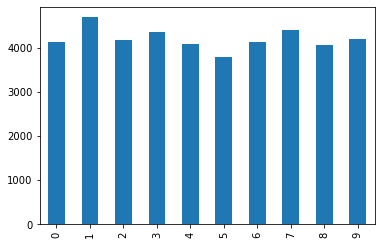

In [3]:
# Examine Data Class Balance & NAN Values

train_data['label'].value_counts().sort_index().plot(kind='bar')
nan_value=train_data.isna().sum().sum()+test_data.isna().sum().sum()
print("There is no Nan values in our data")
print("Looks  we have a a balanced data! GOOD")

y = 0


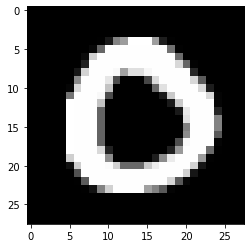

In [4]:
#Visualize One Example
index=4  
a=np.array(train_data.iloc[index,1:]).reshape(28,28,1)
plt.imshow(a,cmap='gray')
print ("y = " + str(train_data.iloc[index, 1]))

In [5]:
# Reshape  Data

n_classes=10
#Reshape our input to 3D 
X_train_=np.array(train_data.drop(columns='label')).reshape(-1,28,28,1)
X_test=np.array(test_data).reshape(-1,28,28,1)

# One hot Vectorize our target
y_train=to_categorical(train_data.label,n_classes)


print ("X_train shape: " + str(X_train_.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))


X_train shape: (42000, 28, 28, 1)
Y_train shape: (42000, 10)
X_test shape: (28000, 28, 28, 1)


In [6]:
# Normalization

X_train_=X_train_/255.
X_test=X_test/255.

In [7]:
# Isolate some Valid Set

X_train, X_val, Y_train, Y_val = train_test_split(X_train_, y_train, test_size = 0.1, random_state=4,stratify = train_data.label)
# Stratify to help creating "Balanced"  valid dataset

## MODEL Definition 


#### Model I 
LeNet-5 Model ref[1]
scored 0.97792 on test data  and scored 0.98821 after data augmnntation

In [8]:

model1=models.Sequential()
model1.add(Conv2D(filters=6,kernel_size=(5,5),activation='relu',input_shape=(28,28,1)))
model1.add(MaxPool2D(pool_size=(2,2),strides=2))
model1.add(Conv2D(filters=16,kernel_size=(5,5),activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2),strides=2))
model1.add(Flatten())
model1.add(Dense(120, activation = "relu"))
model1.add(Dense(84, activation = "relu"))
model1.add(Dense(10, activation = "softmax"))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               30840     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

#### Model II (880K parameters)
This CNN architectire originated from paper ref [2] and implemented on notebook[3]

scored 0.99228 on test data

In [9]:


model2 = models.Sequential()

model2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25))


model2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.25))


model2.add(Flatten())
model2.add(Dense(256, activation = "relu"))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation = "softmax"))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)         

#### ModelIII ref[4]
This model is a modified version of the last model and achieved the highest performance of  0.99403  on test data 


Modifications:

1- Used two CNN layers of (3,3) Kernals instead of one layer (5,5)

2- Used Strides of (2,2) as subsamling instead of PoolMAx Layers so mre parameterd to learn

3- USed Batch Normalization 

In [10]:

model3 = models.Sequential()

model3.add(Conv2D(filters = 32, kernel_size = (3,3),
                 activation ='relu', input_shape = (28,28,1)))
model3.add(BatchNormalization())

model3.add(Conv2D(filters = 32, kernel_size = (3,3),
                 activation ='relu'))
model3.add(BatchNormalization())

model3.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same' ,strides=(2,2),activation ='relu'))
           
model3.add(BatchNormalization())
model3.add(Dropout(0.25))


model3.add(Conv2D(filters = 64, kernel_size = (3,3),
                 activation ='relu'))
model3.add(BatchNormalization())

model3.add(Conv2D(filters = 64, kernel_size = (3,3),
                 activation ='relu'))
model3.add(BatchNormalization())

model3.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', strides=(2,2),
                 activation ='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))


model3.add(Flatten())
model3.add(Dense(128, activation = "relu"))
model3.add(Dropout(0.5))
model3.add(Dense(10, activation = "softmax"))
model3.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 32)       

## Data Augmentation 

In [11]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
)


datagen.fit(X_train)

## Training Third Model

In [12]:
# Stop Training when the quantity monitored "val_accuracy" stopped decreasing  for 5 consequitve epochs
callback1 = EarlyStopping(monitor='loss', patience=5)

# Save the best weights after each epochs 
# Actually My laptop has no battaery so to save the progress if something TERRIBLE happened 
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
callback2 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


callbacklist=[callback1, callback2]


In [13]:
optimizer = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
n_epochs=30

model3.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
history = model3.fit(datagen.flow(X_train,Y_train, batch_size=86),
                              epochs =n_epochs , validation_data = (X_val,Y_val),callbacks=callbacklist)

Epoch 1/30
440/440 [==============================] - ETA: 0s - loss: 1.5231 - accuracy: 0.5321
Epoch 00001: val_accuracy improved from -inf to 0.67643, saving model to weights-improvement-01-0.68.hdf5
440/440 [==============================] - 161s 365ms/step - loss: 1.5231 - accuracy: 0.5321 - val_loss: 0.9486 - val_accuracy: 0.6764
Epoch 2/30
440/440 [==============================] - ETA: 0s - loss: 0.4213 - accuracy: 0.8674
Epoch 00002: val_accuracy improved from 0.67643 to 0.97238, saving model to weights-improvement-02-0.97.hdf5
440/440 [==============================] - 158s 359ms/step - loss: 0.4213 - accuracy: 0.8674 - val_loss: 0.0835 - val_accuracy: 0.9724
Epoch 3/30
440/440 [==============================] - ETA: 0s - loss: 0.2405 - accuracy: 0.9269
Epoch 00003: val_accuracy improved from 0.97238 to 0.97690, saving model to weights-improvement-03-0.98.hdf5
440/440 [==============================] - 159s 361ms/step - loss: 0.2405 - accuracy: 0.9269 - val_loss: 0.0683 - val_

Epoch 28/30
440/440 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9873
Epoch 00028: val_accuracy did not improve from 0.99262
440/440 [==============================] - 158s 360ms/step - loss: 0.0470 - accuracy: 0.9873 - val_loss: 0.0275 - val_accuracy: 0.9914
Epoch 29/30
440/440 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9884
Epoch 00029: val_accuracy did not improve from 0.99262
440/440 [==============================] - 157s 357ms/step - loss: 0.0421 - accuracy: 0.9884 - val_loss: 0.0398 - val_accuracy: 0.9907
Epoch 30/30
440/440 [==============================] - ETA: 0s - loss: 0.0446 - accuracy: 0.9879
Epoch 00030: val_accuracy did not improve from 0.99262
440/440 [==============================] - 157s 357ms/step - loss: 0.0446 - accuracy: 0.9879 - val_loss: 0.0355 - val_accuracy: 0.9905


In [ ]:
## Load best weights to model 
#model3.load_weights("weights-improvement-11-0.99.hdf5")


### Model Evaluation

<AxesSubplot:>

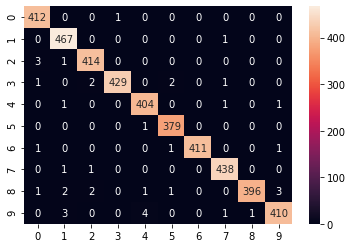

In [14]:
# Let's Build the confusion Matrix so give us indication about the points where the model fails

Y_true = np.argmax(Y_val,axis = 1) 
pred_val_=np.argmax(model3.predict(X_val),axis=1)
conf_matrix= confusion_matrix(Y_true,pred_val_)
sns.heatmap(conf_matrix, annot=True, fmt='d')


In [18]:
# Observation from the confusion Matrix 
print("from the confusion matrix Above.. the most misclafied label is 4 and it is classfied as 9, The only digit that has accuracy of 100% is number 6")


from the confusion matrix Above.. the most misclafied label is 4 and it is classfied as 9, The only digit that has accuracy of 100% is number 6


Text(0.5, 1.0, 'accuracy vs iterations ')

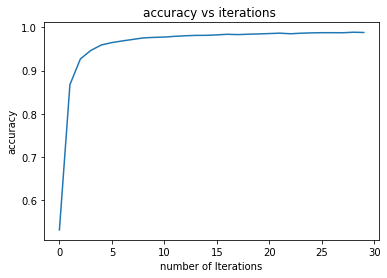

In [16]:
# accuracy vs iterations Plot
plt.plot(history.history["accuracy"])
plt.xlabel("number of Iterations")
plt.ylabel("accuracy")
plt.title("accuracy vs iterations ")

#### Submitting To Kaggle 

In [17]:
y_pred=model3.predict(X_test)
y_pred_final=[]
for i in range(len(X_test)):
    y_pred_final.append(y_pred[i,:].argmax())
    
sub=pd.DataFrame({"Label":y_pred_final},dtype=np.int64)
sub.index=pd.RangeIndex(start=1, stop=28001, step=1)
sub.index.rename("ImageId",inplace=True)
sub.to_csv("sub.csv",index=True)

#### References :
[1]LeCun et all., 1998.Gradient-Based Learning applied to document recognition
[2] Siddique, Fathma & Sakib, Shadman & Siddique, Md. Abu. (2019). Recognition of Handwritten Digit using Convolutional Neural Network in Python with Tensorflow and Comparison of Performance for Various Hidden Layers. 10.20944/preprints201903.0039.v2. 
[3] https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6#2.-Data-preparation
[4] https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist

